In [43]:
from typing import Optional, Union, Any

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sb
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Helper Functions <br>
(We can put them in a separate file and import them, but for now, I just put them here)

In [3]:
def calculate_rule_support(df: pd.DataFrame, body_and_head_values: dict[str, str]) -> float:
    """
    Calculates the support of the rule body -> head
    
    :param df: dataframe to calculate the support
    :param body_and_head_values: dictionary of column names and values for the rule
    :return: support of the rule
    """
    no_rows = df.shape[0]
    support = 0

    for i in range(no_rows):
        is_rule_satisfied = True
        for column, value in body_and_head_values.items():
            if df[column][i] != value:
                is_rule_satisfied = False
                break

        if is_rule_satisfied:
            support += 1

    if no_rows == 0:
        return 0

    return support / no_rows


def calculate_rule_confidence(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> float:
    """
    Calculates the confidence of the rule body -> head
    
    :param df: dataframe to calculate the confidence
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: confidence of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    body_and_head_support = calculate_rule_support(df, {**body_values, **head_values})

    if body_support == 0:
        return 0

    return body_and_head_support / body_support


def calculate_rule_lift(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> float:
    """
    Calculates the lift of the rule body -> head
    
    :param df: dataframe to calculate the lift
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: lift of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    head_support = calculate_rule_support(df, head_values)
    body_and_head_support = calculate_rule_support(df, {**body_values, **head_values})

    if body_support * head_support == 0:
        return 0

    return body_and_head_support / (body_support * head_support)


def find_rule_info(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> dict[str, float]:
    """
    Finds the support, confidence and lift of the rule body -> head
    
    :param df: dataframe to find the rule info
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: dictionary of rule info
    """
    rule_info = {'support': calculate_rule_support(df, {**body_values, **head_values}),
                 'confidence': calculate_rule_confidence(df, body_values, head_values),
                 'lift': calculate_rule_lift(df, body_values, head_values)}

    return rule_info


def find_every_1_to_1_rule(df: pd.DataFrame,
                           numerical_columns: list[str],
                           categorical_columns: list[str],
                           head_column_name: str,
                           body_column_name: Optional[str] = None,
                           ) -> pd.DataFrame:
    """
    Finds every 1 to 1 rule for the given column
    
    :param df: dataframe to find the rules
               If there are any numerical columns they have to change as {column_name}_exists column 
                    to indicate that the value is missing or not (0 missing, 1 exists)
               And if there is any NaN value in categorical columns, it should be filled with 'NaN'
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :param head_column_name: column name to use as head of the rule
    :param body_column_name: column name to use as body of the rule
    :return: dataframe of rules
    """
    if not head_column_name in df.columns:
        raise ValueError(f"Column {head_column_name} is not in the dataframe.")
    if body_column_name and not body_column_name in df.columns:
        raise ValueError(f"Column {body_column_name} is not in the dataframe.")
    if body_column_name and body_column_name == head_column_name:
        raise ValueError("Body column and head column cannot be the same.")
    
    df_exists = df.copy()
    # just keep the columns that are in the numerical_columns and categorical_columns
    df_exists = df_exists[numerical_columns + categorical_columns]

    # for numerical columns create a new column to show that the value is missing or not, drop the original column
    for column in numerical_columns:
        df_exists[column] = df_exists[column].fillna(-1)
        # change the values to -1 if the value is missing, 0 if the value is actually 0, 1 if the value is not missing
        df_exists[column] = df_exists[column].apply(lambda x: 0 if x == 0 else -1 if x == -1 else 1)
        
    # for categorical columns fill NaN values with 'NaN'
    for column in categorical_columns:
        df_exists[column] = df_exists[column].fillna('NaN')        
        
    rules = pd.DataFrame(columns=['Body_Name', 'Body_Value', 'Head_Name', 'Head_Value', 'Support', 'Confidence', 'Lift'])
    unique_values_in_head_column = df_exists[head_column_name].unique()

    other_columns = df_exists.columns.tolist() if not body_column_name else [body_column_name]
    other_columns.remove(head_column_name) if head_column_name in other_columns else None
        
    for other_column in other_columns:
        
        # select the unique values in the column
        unique_values_in_body_column = df_exists[other_column].unique()

        for other_value in unique_values_in_body_column:
            body_values = {other_column: other_value}
            for value in unique_values_in_head_column:
                head_values = {head_column_name: value}
                rule_info = find_rule_info(df_exists, body_values, head_values)
                # if support is 0, then there is no need to add the rule
                if rule_info['support'] > 0:
                    rules.loc[rules.shape[0]] = [other_column, other_value, head_column_name, value, rule_info['support'], rule_info['confidence'], rule_info['lift']]
    
    # in body_value, and head_value columns, change -1 to NaN, 1 to Exists, 0 to Exists as 0 in rule_info
    rules['Body_Value'] = rules['Body_Value'].apply(lambda x: 'NaN' if x == -1 else 'Exists' if x == 1 else 'Exists as 0' if x == 0 else x)
    rules['Head_Value'] = rules['Head_Value'].apply(lambda x: 'NaN' if x == -1 else 'Exists' if x == 1 else 'Exists as 0' if x == 0 else x)
    
    return rules

def create_numerical_imputer(df: pd.DataFrame,
                             numerical_columns: list[str]) -> KNNImputer:
    """
    Creates a KNN imputer for the numerical columns
    
    :param df: dataframe to create the imputer
    :param numerical_columns: list of numerical columns in the dataframe
    :return: KNN imputer for the numerical columns
    """
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    imputer.fit(df[numerical_columns])
    
    return imputer


def create_categorical_imputer(df: pd.DataFrame,
                               categorical_columns: list[str]) -> object:
    """
    Creates a Naive Bayes imputer for the categorical columns
    
    :param df: dataframe to create the imputer
    :param categorical_columns: list of categorical columns in the dataframe
    :return: Naive Bayes imputer for the categorical columns
    """
    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(df[categorical_columns])
    
    return imputer

# IMPORTANT: I faced with lots of errors when I try to use the imputers, so I just put mean for numerical columns and most frequent value for categorical columns for now
def imputation_of_missing_values_in_row(row: pd.Series,
                                        train_data: pd.DataFrame,
                                        numerical_columns: list[str],
                                        categorical_columns: list[str],
                                        allowed_nan_columns: list[str],
                                        numerical_imputer: Any,
                                        categorical_imputer: Any) -> pd.Series:
    """
    Imputes the missing values in the given row
    
    :param row: row to impute the missing values
    :param train_data: training data to use for imputation
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :param allowed_nan_columns: list of columns that can have NaN values
    :param numerical_imputer: imputer for numerical columns
    :param categorical_imputer: imputer for categorical columns
    :return: imputed row
    """
    row_copy = row.copy()
    raw_columns = row_copy.index.tolist()  # get the columns of the row
    
    # change the NaN values in the columns that are not in the allowed_nan_columns to 'NaN'
    for column in allowed_nan_columns:
        if pd.isna(row_copy[column]):
            row_copy[column] = 'NaN'
    
    for column in raw_columns:
        value_in_column = row_copy[column]
        if pd.isna(value_in_column):
    
            # if the column is 'GarageYrBlt' and 'GarageCond' is 'NaN', then fill the missing value with 0
            if column == 'GarageYrBlt' and row_copy['GarageCond'] == 'NaN':
                row_copy[column] = 0
                
            # if the column is 'MasVnrArea' and 'MasVnrType' is 'NaN', then fill the missing value with 0
            elif column == 'MasVnrArea' and row_copy['MasVnrType'] == 'NaN':
                row_copy[column] = 0
                
            # if the column is 'Electrical', then fill the missing value with the most frequent value
            elif column == 'Electrical':
                row_copy[column] = 'SBrkr'
                
            # if the column is in the numerical columns, then fill the missing value with the predicted value by the numerical imputer
            elif column in numerical_columns:
                # row_copy[column] = numerical_imputer.fit_transform(row_copy[column])
                # just put mean of TRAIN_DATA for now
                row_copy[column] = train_data[column].mean()
                
            # if the column is in the categorical columns, then fill the missing value with the predicted value by the categorical imputer
            elif column in categorical_columns:
                # row_copy[column] = categorical_imputer.fit_transform(row_copy[column])
                # just put most frequent value of TRAIN_DATA for now
                row_copy[column] = train_data[column].mode()[0]
                
            else:
                raise ValueError(f"Column {column} is not in the numerical columns or categorical columns")
                
    return row_copy

# Read Data from CSV Files

In [4]:
TRAIN_DATA = pd.read_csv('data/train.csv')
TEST_DATA = pd.read_csv('data/test.csv')
WHOLE_DATA = pd.concat([TRAIN_DATA, TEST_DATA], ignore_index=True)

print(f"Train data shape: {TRAIN_DATA.shape}")
print(f"Test data shape: {TEST_DATA.shape}")
print(f"Whole data shape: {WHOLE_DATA.shape}")

Train data shape: (1460, 81)
Test data shape: (1459, 80)
Whole data shape: (2919, 81)


In [5]:
WHOLE_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

### Finding numerical feature columns and categorical feature columns
- For Target column, we know that it is SalePrice
- For numerical columns, we have to remove Id column because it is not a feature, Target column because it is the target, and MSSubClass column because it is a categorical column (we know that from the data description)
- For categorical columns, we have to add MSSubClass column

In [6]:
# find numerıcal columns and categorical columns
TARGET_COLUMN = 'SalePrice'

TRAIN_DATA['MSSubClass'] = TRAIN_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical
TEST_DATA['MSSubClass'] = TEST_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical
WHOLE_DATA['MSSubClass'] = WHOLE_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical

NUMERICAL_COLUMNS = WHOLE_DATA.select_dtypes(include=['int64', 'float64']).columns.tolist()
NUMERICAL_COLUMNS.remove(TARGET_COLUMN)
NUMERICAL_COLUMNS.remove('Id')  # remove Id column because it is not a feature

CATEGORICAL_COLUMNS = WHOLE_DATA.select_dtypes(include=['object']).columns.tolist()

print(f"Target column: {TARGET_COLUMN} \n")
print(f"Numerical columns ({len(NUMERICAL_COLUMNS)}): \n{NUMERICAL_COLUMNS} \n")
print(f"Categorical columns ({len(CATEGORICAL_COLUMNS)}): \n{CATEGORICAL_COLUMNS}")

Target column: SalePrice 

Numerical columns (35): 
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 

Categorical columns (44): 
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'F

# Detection and Imputation of Missing Values

In [7]:
DATA_FRAME = WHOLE_DATA.copy()
DATA_FRAME.drop(columns=[TARGET_COLUMN, 'Id'], inplace=True)

MISSING_DATA_INFO = pd.concat([DATA_FRAME.isnull().sum().sort_values(ascending = False),
                              (DATA_FRAME.isnull().sum()/WHOLE_DATA.isnull().count()).sort_values(ascending = False),   
                              ], axis = 1, keys = ['Total', 'Percent'])
# add also that the column is categorical or numerical to the first column
MISSING_DATA_INFO['Type'] = 'Numerical'
MISSING_DATA_INFO.loc[CATEGORICAL_COLUMNS, 'Type'] = 'Categorical'

# drop the rows that have no missing values
MISSING_DATA_INFO = MISSING_DATA_INFO[MISSING_DATA_INFO['Total'] > 0]

# also add a column that shows the where is the missing value in Train or Test data or both
MISSING_DATA_INFO['Missing Data Location'] = 'Train + Test'
for COLUMN in MISSING_DATA_INFO.index:
    if TRAIN_DATA[COLUMN].isnull().sum() == 0:
        MISSING_DATA_INFO.loc[COLUMN, 'Missing Data Location'] = 'Test'
    elif TEST_DATA[COLUMN].isnull().sum() == 0:
        MISSING_DATA_INFO.loc[COLUMN, 'Missing Data Location'] = 'Train'
        
# As we see from the data description, some categorical columns can have NaN values, but they are not considered as missing values. We need to convert them to string 'NaN' to use them in the algorithms.
ALLOWED_NAN_COLUMNS = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                       'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

# change NaN values in the columns that are not in the ALLOWED_NAN_COLUMNS to 'NaN', and drop the rows from MISSING_DATA_INFO
for COLUMN in ALLOWED_NAN_COLUMNS:
    MISSING_DATA_INFO.drop(index=COLUMN, inplace=True)
    DATA_FRAME[COLUMN] = DATA_FRAME[COLUMN].fillna('NaN')
        
# reorder the columns
MISSING_DATA_INFO = MISSING_DATA_INFO[['Type', 'Missing Data Location', 'Total', 'Percent']]
        
MISSING_DATA_INFO

,Type,Missing Data Location,Total,Percent
LotFrontage,Numerical,Train + Test,486.0,0.166495
GarageYrBlt,Numerical,Train + Test,159.0,0.054471
MasVnrArea,Numerical,Train + Test,23.0,0.007879
MSZoning,Categorical,Test,4.0,0.001370
BsmtHalfBath,Numerical,Test,2.0,0.000685
Utilities,Categorical,Test,2.0,0.000685
BsmtFullBath,Numerical,Test,2.0,0.000685
Functional,Categorical,Test,2.0,0.000685
TotalBsmtSF,Numerical,Test,1.0,0.000343
BsmtFinSF1,Numerical,Test,1.0,0.000343


## 1- Inspection of Correlation Between Missing Values
(For this inspection, we only use training data because using test data to come up with a strategy to fill missing values is not a fair-play)

In [8]:
def correlation_matrix_for_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Finds the correlation matrix of the dataframe for the missing values
    
    :param df: dataframe
    :return: correlation matrix of the dataframe
    """
    df_copy = df.copy()
    
    df_copy.replace(pd.NA, None, inplace=True)
    df_copy.replace('NaN', None, inplace=True)
    
    heatmap_plot = msno.heatmap(df_copy)
    plt.title('Correlation Between Missing Values', fontsize=30)
    
    return heatmap_plot    

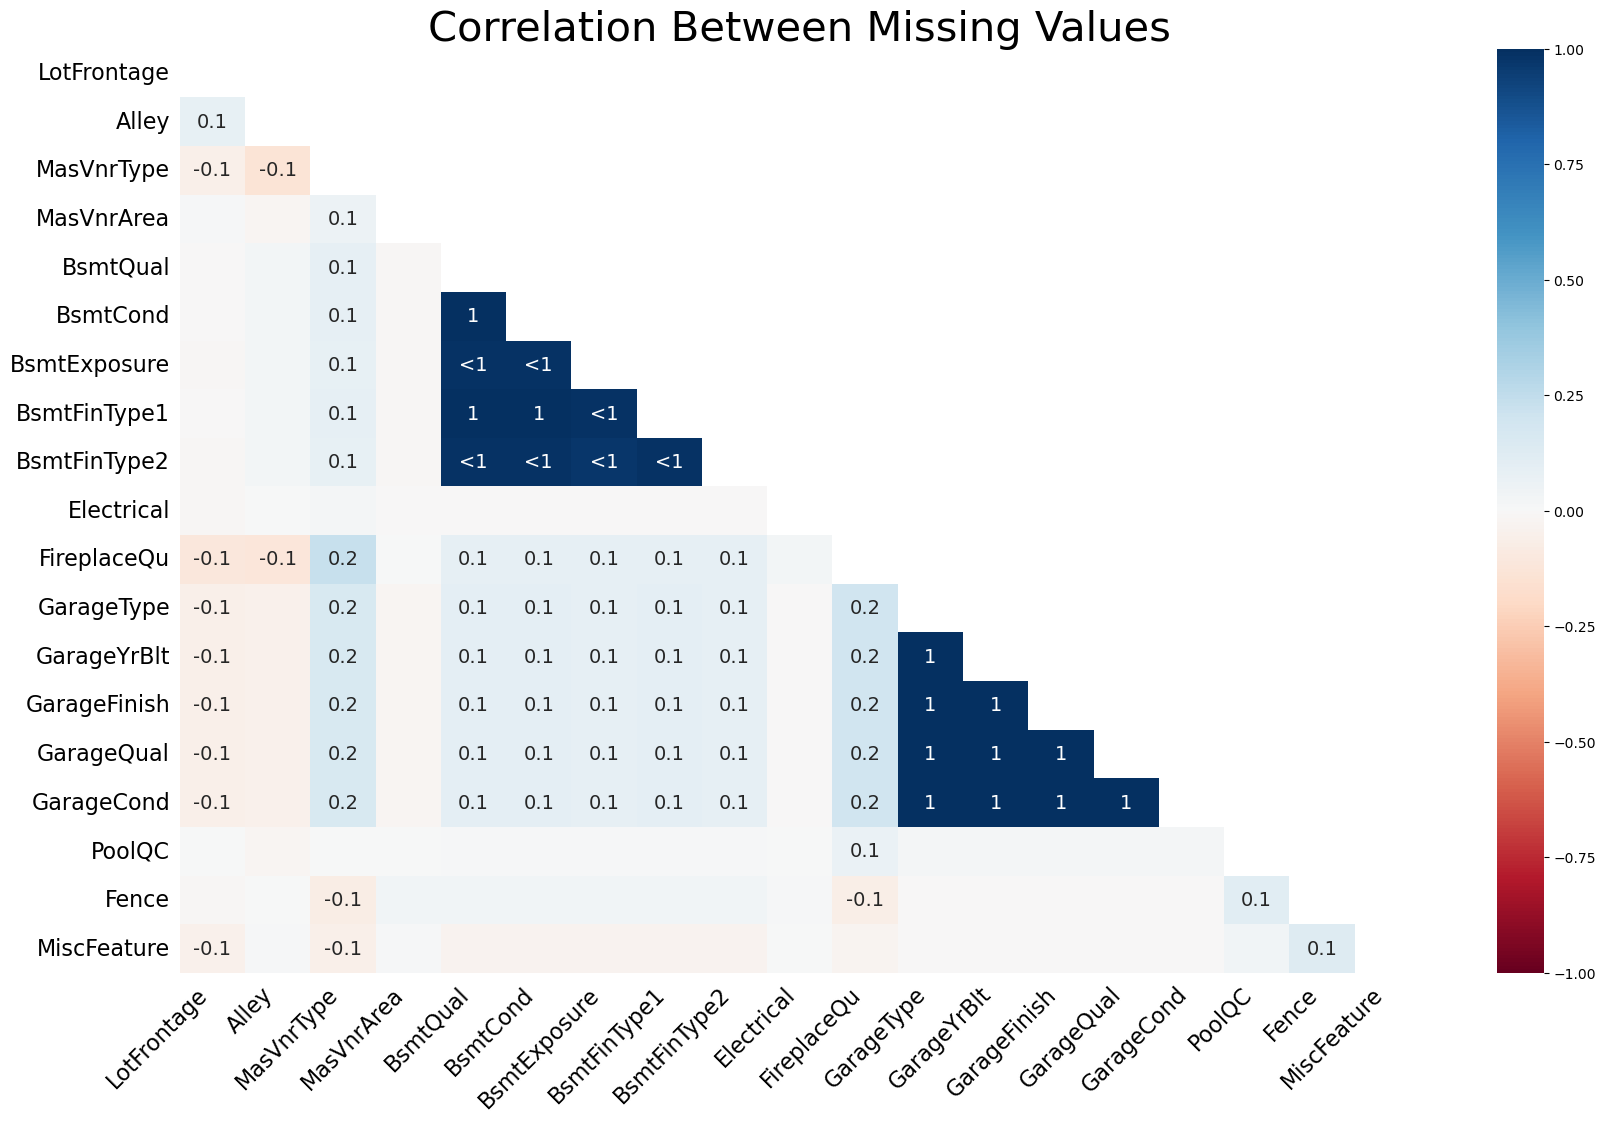

In [9]:
correlation_matrix_for_missing_values(TRAIN_DATA)
plt.show()

#### So as we can see from the heatmap, there is a strong correlation missing values between some columns. We can use this information to fill the missing values in the columns.

#### As we can see from the table 'LotFrontage' has no significant correlation with other columns. So we will impute the missing values in this column in next steps. (We can fill the missing values with KNN imputer, mean imputer, etc.)

#### 'GarageYrBlt' has a strong correlation with other columns about Garage. So we can use this information to fill the missing values in this column.

In [10]:
# find the 1 to 1 rules for the column GarageYrBlt in the TRAIN_DATA
find_every_1_to_1_rule(df=TRAIN_DATA,
                       numerical_columns=NUMERICAL_COLUMNS,
                       categorical_columns=CATEGORICAL_COLUMNS,
                       head_column_name='GarageYrBlt',
                       body_column_name='GarageCond').head(6)

,Body_Name,Body_Value,Head_Name,Head_Value,Support,Confidence,Lift
0,GarageCond,TA,GarageYrBlt,Exists,0.908219,1.0,1.058738
1,GarageCond,Fa,GarageYrBlt,Exists,0.023973,1.0,1.058738
2,GarageCond,NaN,GarageYrBlt,NaN,0.055479,1.0,18.024691
3,GarageCond,Gd,GarageYrBlt,Exists,0.006164,1.0,1.058738
4,GarageCond,Po,GarageYrBlt,Exists,0.004795,1.0,1.058738
5,GarageCond,Ex,GarageYrBlt,Exists,0.001370,1.0,1.058738


What we can understand is that if 'GarageCond' is 'NaN', then it is normal that 'GarageYrBlt' is 'NaN' (confidence of the rule GarageCond = NaN -> GarageYrBlt = NaN is 1 in train set). <br>
However, we cannot leave it as 'NaN' so we choose to fill the missing values in 'GarageYrBlt' as 0 for train set. <br>
If in the test set, 'GarageCond' is 'NaN' and 'GarageYrBlt' is also 'NaN', then we can fill the missing values in 'GarageYrBlt' as 0. Otherwise, we have to impute its value by using a strategy (like KNN imputer, mean imputer, etc.) because when 'GarageCond' is not 'NaN', 'GarageYrBlt' is not 'NaN' (confidence of the rule GarageCond != NaN -> GarageYrBlt != NaN is almost 1). <br>

#### 'MasVnrArea' has a strong correlation with 'MasVnrType'. So we can use this information to fill the missing values in this column.

In [11]:
# find the 1 to 1 rules for the column MasVnrArea in the TRAIN_DATA
find_every_1_to_1_rule(df=TRAIN_DATA,
                       numerical_columns=NUMERICAL_COLUMNS,
                       categorical_columns=CATEGORICAL_COLUMNS,
                       head_column_name='MasVnrArea',
                       body_column_name='MasVnrType').head(8)

,Body_Name,Body_Value,Head_Name,Head_Value,Support,Confidence,Lift
0,MasVnrType,BrkFace,MasVnrArea,Exists,0.304110,0.997753,2.464838
1,MasVnrType,BrkFace,MasVnrArea,Exists as 0,0.000685,0.002247,0.003811
2,MasVnrType,NaN,MasVnrArea,Exists,0.003425,0.005734,0.014165
3,MasVnrType,NaN,MasVnrArea,Exists as 0,0.588356,0.985092,1.670423
4,MasVnrType,NaN,MasVnrArea,NaN,0.005479,0.009174,1.674312
5,MasVnrType,Stone,MasVnrArea,Exists,0.086986,0.992188,2.451089
6,MasVnrType,Stone,MasVnrArea,Exists as 0,0.000685,0.007812,0.013248
7,MasVnrType,BrkCmn,MasVnrArea,Exists,0.010274,1.000000,2.470389


What we can understand is that if 'MasVnrType' is 'NaN', then 'MasVnrArea' should be 0 (confidence of the rule MasVnrType = NaN -> MasVnrArea = 0 is almost 1). <br>
We know that for train set, it is like that, but for test set, if 'MasVnrType' is not 'NaN' when 'MasVnrArea' is 'NaN', then we have to impute its value by using a strategy (like KNN imputer, mean imputer, etc.) because the confidence of the rules: <br>
- MasVnrType = BrkFace -> MasVnrArea > 0 (confidence is almost 1)
- MasVnrType = Stone -> MasVnrArea > 0 (confidence is almost 1)
- MasVnrType = BrkCmn -> MasVnrArea > 0 (confidence is 1) 


#### 'Electrical' has no strong correlation with other columns. So we will impute the missing values in this column in next steps. (We can fill the missing values with the most frequent value)

In [12]:
print(f"Most frequent value in 'Electrical' column: {TRAIN_DATA['Electrical'].mode()[0]}")

Most frequent value in 'Electrical' column: SBrkr


## 2- Imputation of Missing Values

In [13]:
NUMERICAL_IMPUTER = create_numerical_imputer(TRAIN_DATA, NUMERICAL_COLUMNS)
CATEGORICAL_IMPUTER = create_categorical_imputer(TRAIN_DATA, CATEGORICAL_COLUMNS)

In [14]:
IMPUTED_TRAIN_DATA = TRAIN_DATA.copy()
IMPUTED_TRAIN_DATA.drop(columns=['Id'], inplace=True)
IMPUTED_TRAIN_DATA = IMPUTED_TRAIN_DATA.apply(lambda x: imputation_of_missing_values_in_row(x,
                                                                                            IMPUTED_TRAIN_DATA,
                                                                                            NUMERICAL_COLUMNS,
                                                                                            CATEGORICAL_COLUMNS,
                                                                                            ALLOWED_NAN_COLUMNS,
                                                                                            NUMERICAL_IMPUTER,
                                                                                            CATEGORICAL_IMPUTER), axis=1)

# Data Analysis and Visualization

### 1- Showing some distributions of the columns to understand the data better

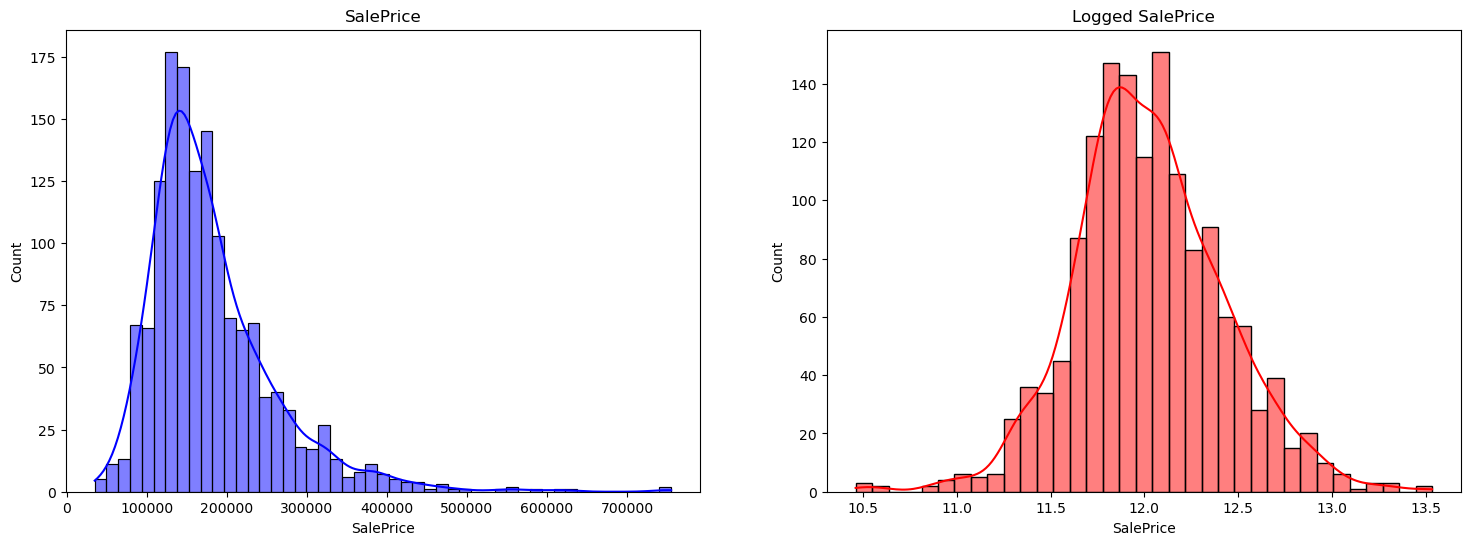

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.196,79442.503,34900.0,129975.0,163000.0,214000.0,755000.0


In [15]:
# put normal and logged SalePrice side by side
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# show normal SalePrice distribution
sns.histplot(TRAIN_DATA[TARGET_COLUMN], color='blue', kde=True, ax=ax[0])
ax[0].set_title("SalePrice")

# show logged SalePrice distribution
sns.histplot(np.log1p(TRAIN_DATA[TARGET_COLUMN]), color='red', kde=True, ax=ax[1])
ax[1].set_title("Logged SalePrice")

plt.show()

# print descriptive statistics as table
pd.DataFrame(TRAIN_DATA[TARGET_COLUMN].describe()).T.round(3)

### 2- Outlier Detection

In [16]:
#Refer to Outlier Analysis Notebook for reasoning
#Drop outliers
IMPUTED_TRAIN_DATA = IMPUTED_TRAIN_DATA[IMPUTED_TRAIN_DATA["LotArea"] < 100000]
IMPUTED_TRAIN_DATA = IMPUTED_TRAIN_DATA[IMPUTED_TRAIN_DATA["LotFrontage"] < 200]
IMPUTED_TRAIN_DATA = IMPUTED_TRAIN_DATA[IMPUTED_TRAIN_DATA["GrLivArea"] < 4500]
IMPUTED_TRAIN_DATA = IMPUTED_TRAIN_DATA[IMPUTED_TRAIN_DATA["MasVnrArea"] < 1500]
IMPUTED_TRAIN_DATA.shape

(1452, 80)

# Feature Engineering and Selection

## 1- Creating New Features

In [17]:
#Create new features 
def add_features(df):
    df['overall cond-qual']        = df['OverallQual']  + df['OverallCond']
    df['YearRemodAdd-YearBuilt ']  = df['YearRemodAdd'] - df['YearBuilt']
    df['first-secondFlrSf']        = df['1stFlrSF']     + df['2ndFlrSF']
    df['BsmtBaths']                = df['BsmtFullBath'] + df['BsmtHalfBath']*0.5
    df['AboveBaths']               = df['FullBath']     + df['HalfBath']*0.5
    df['TotalBaths']               = df['BsmtBaths']    + df['AboveBaths']
    df['PorchArea']                = df['OpenPorchSF']  + df['EnclosedPorch'] + \
                                     df['3SsnPorch']    + df['ScreenPorch']
    return df

In [31]:
IMPUTED_TRAIN_DATA = add_features(IMPUTED_TRAIN_DATA)
IMPUTED_TRAIN_DATA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452 entries, 0 to 1459
Data columns (total 87 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MSSubClass               1452 non-null   object 
 1   MSZoning                 1452 non-null   object 
 2   LotFrontage              1452 non-null   float64
 3   LotArea                  1452 non-null   int64  
 4   Street                   1452 non-null   object 
 5   Alley                    1452 non-null   object 
 6   LotShape                 1452 non-null   object 
 7   LandContour              1452 non-null   object 
 8   Utilities                1452 non-null   object 
 9   LotConfig                1452 non-null   object 
 10  LandSlope                1452 non-null   object 
 11  Neighborhood             1452 non-null   object 
 12  Condition1               1452 non-null   object 
 13  Condition2               1452 non-null   object 
 14  BldgType                 1452

## 2- ARM to Find Association Rules

In [19]:
from mlxtend.frequent_patterns import apriori, association_rules

In [20]:
#Get categorical features only
categorical_columns = IMPUTED_TRAIN_DATA.select_dtypes(include=['object', 'category']).columns.tolist()
IMPUTED_TRAIN_DATA_CATEGORICAL = IMPUTED_TRAIN_DATA[categorical_columns]
IMPUTED_TRAIN_DATA_CATEGORICAL.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [21]:
#One-hot encode the categorical features
one_hot_train_data = pd.get_dummies(IMPUTED_TRAIN_DATA_CATEGORICAL)
frequent_itemsets = apriori(one_hot_train_data, min_support=0.8, use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                antecedents             consequents   support  confidence  \
0               (Alley_NaN)           (Street_Pave)  0.934573    0.996329   
1             (Street_Pave)             (Alley_NaN)  0.934573    0.937802   
2         (LandContour_Lvl)           (Street_Pave)  0.900826    0.998473   
3             (Street_Pave)       (LandContour_Lvl)  0.900826    0.903939   
4             (Street_Pave)      (Utilities_AllPub)  0.995868    0.999309   
..                      ...                     ...       ...         ...   
399            (PoolQC_NaN)           (SaleType_WD)  0.864325    0.867911   
400  (SaleCondition_Normal)            (PoolQC_NaN)  0.818871    0.997483   
401            (PoolQC_NaN)  (SaleCondition_Normal)  0.818871    0.822268   
402       (MiscFeature_NaN)           (SaleType_WD)  0.836088    0.867143   
403           (SaleType_WD)       (MiscFeature_NaN)  0.836088    0.962728   

         lift  
0    0.999772  
1    0.999772  
2    1.001923  
3    1.0019

In [30]:
#Filter rules with lift greater than 1
strong_rules = rules[rules['lift'] > 1]
strong_rules = strong_rules.sort_values(by='lift', ascending=False)

print(strong_rules.head(20))


            antecedents         consequents  antecedent support  \
376     (GarageCond_TA)     (GarageQual_TA)            0.907713   
377     (GarageQual_TA)     (GarageCond_TA)            0.897383   
86    (LandContour_Lvl)     (LandSlope_Gtl)            0.902204   
87      (LandSlope_Gtl)   (LandContour_Lvl)            0.949725   
385     (GarageCond_TA)      (PavedDrive_Y)            0.907713   
384      (PavedDrive_Y)     (GarageCond_TA)            0.917355   
378      (PavedDrive_Y)     (GarageQual_TA)            0.917355   
379     (GarageQual_TA)      (PavedDrive_Y)            0.897383   
343     (GarageCond_TA)      (CentralAir_Y)            0.907713   
342      (CentralAir_Y)     (GarageCond_TA)            0.934573   
336      (CentralAir_Y)  (Electrical_SBrkr)            0.934573   
337  (Electrical_SBrkr)      (CentralAir_Y)            0.913912   
341     (GarageQual_TA)      (CentralAir_Y)            0.897383   
340      (CentralAir_Y)     (GarageQual_TA)            0.93457

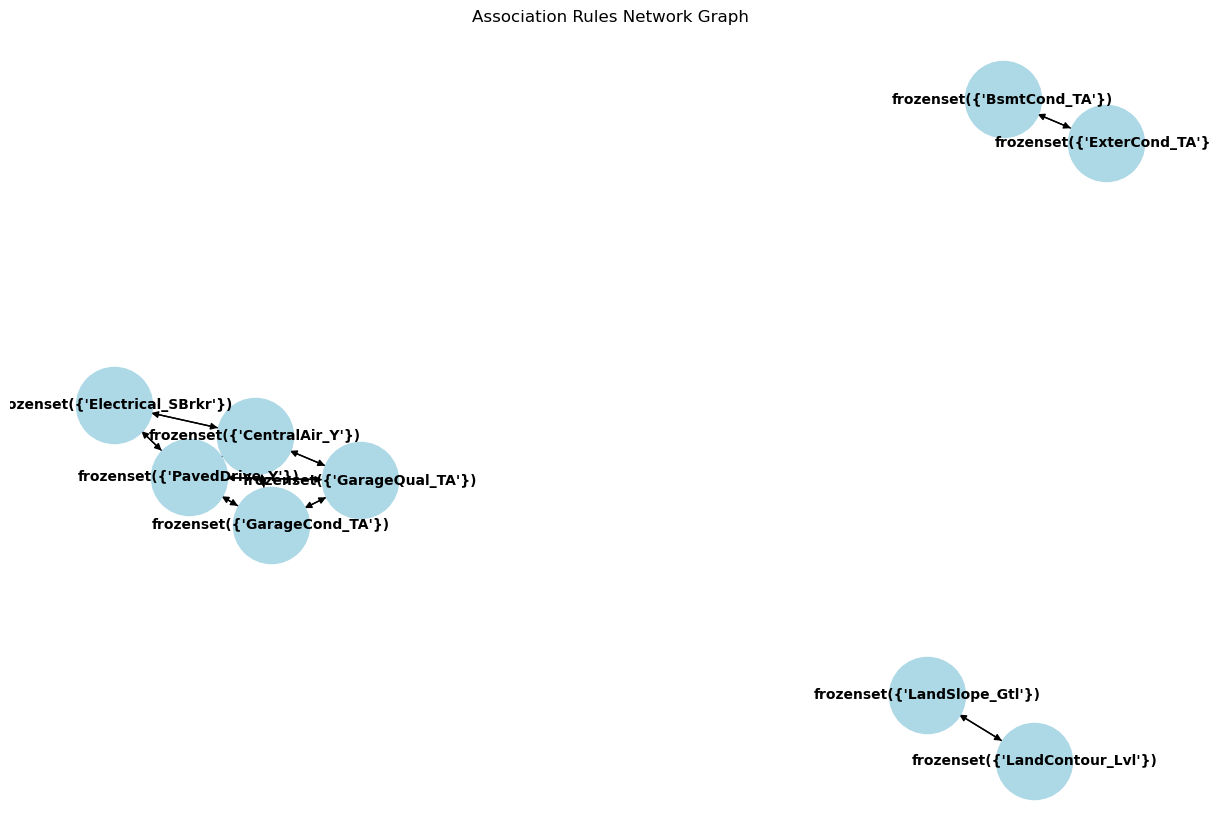

In [29]:
#Visualize Rules
import networkx as nx

# Create a graph
G = nx.from_pandas_edgelist(
    strong_rules.head(20),
    source='antecedents',
    target='consequents',
    edge_attr=True,
  create_using=nx.DiGraph()
)

#Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title('Association Rules Network Graph')
plt.show()


## 3- Lasso Regression for Feature Selection

In [34]:
#Target variables and feature set
y = IMPUTED_TRAIN_DATA['SalePrice']
X = IMPUTED_TRAIN_DATA.drop(['SalePrice'], axis=1)

categorical_columns = IMPUTED_TRAIN_DATA.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64','float64']).columns.tolist()

#Normalize numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#One hot encode categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [35]:
#Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
#Lasso and preprocessing pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=42))
])

#Parameter grid for alpha
param_grid = {
    #From 0.0001 to 10
    'lasso__alpha': np.logspace(-4,1,50)
}

In [40]:
#Perform grid search, optimize with cross-validation
grid_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)


/Users/ryan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148539423610.2993, tolerance: 629261923.8334641
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ryan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133974181803.67097, tolerance: 574878553.5223515
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ryan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150713762045.7452, tolerance: 662920088.7935984
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ryan/anaconda3/lib/python3.10/site-packages/sklearn/line

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          '2nd...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])},
             scoring='neg_mean_squared_error')

In [41]:
#Get best alpha value and score
best_alpha = grid_search.best_params_['lasso__alpha']
best_score = -grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best CV MSE: {best_score}")

Best alpha: 10.0
Best CV MSE: 737691441.9050865


In [42]:
#Fit LASSO Regression Model with Best Alpha
lasso_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=best_alpha, random_state=42))
])
lasso_best.fit(X_train, y_train)

/Users/ryan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26666746779.89746, tolerance: 763759700.1727586
  model = cd_fast.sparse_enet_coordinate_descent(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLiv...
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir', ...])])),
                ('lasso', Lasso(alpha=10.0, random_state=42))])

In [44]:
#Model performance
y_pred = lasso_best.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
print(f"Validation MSE: {mse}")

rmse = np.sqrt(mse)
print(f"Validation RMSE: {rmse}")

r2 = r2_score(y_val, y_pred)
print(f"Validation R^2 Score: {r2}")

Validation MSE: 690667808.9472593
Validation RMSE: 26280.559525003635
Validation R^2 Score: 0.8646556173041671


In [48]:
#Extract Useful Feature Names
onehot_features = lasso_best.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)

all_features = numerical_columns + list(onehot_features)

#Retrieve Coefficients
coefficients = lasso_best.named_steps['lasso'].coef_

#Create a DataFrame to display feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})

#Sort by absolute value of coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display the top features
print(feature_importance.head(20))

                   Feature    Coefficient  Abs_Coefficient
269          GarageQual_Ex  103555.100165    103555.100165
275          GarageCond_Ex  -69823.310040     69823.310040
284              PoolQC_Ex   47705.809735     47705.809735
106   Neighborhood_StoneBr   45072.498862     45072.498862
304           SaleType_New   42038.057094     42038.057094
149       RoofMatl_WdShngl   41742.687634     41742.687634
122        Condition2_PosN  -31779.649806     31779.649806
312  SaleCondition_Partial  -31400.297019     31400.297019
297       MiscFeature_TenC  -27625.847593     27625.847593
198        Foundation_Wood  -27268.090811     27268.090811
285              PoolQC_Fa  -25582.386807     25582.386807
114        Condition1_RRAe  -24840.335970     24840.335970
12                2ndFlrSF   23963.857932     23963.857932
121        Condition2_PosA   23757.791223     23757.791223
84           LandSlope_Sev  -23535.041360     23535.041360
184           ExterQual_Ex   23155.313286     23155.3132

In [51]:
#Get features with non-zero coefficients
important_features = feature_importance[feature_importance['Coefficient'] != 0]['Feature'].tolist()

#Total features before Lasso = 35 numerical + 280 categorical (one hot encoded)
print(f"Number of important features: {len(important_features)}")
print("Important features:")
print(important_features)

Number of important features: 224
Important features:
['GarageQual_Ex', 'GarageCond_Ex', 'PoolQC_Ex', 'Neighborhood_StoneBr', 'SaleType_New', 'RoofMatl_WdShngl', 'Condition2_PosN', 'SaleCondition_Partial', 'MiscFeature_TenC', 'Foundation_Wood', 'PoolQC_Fa', 'Condition1_RRAe', '2ndFlrSF', 'Condition2_PosA', 'LandSlope_Sev', 'ExterQual_Ex', 'RoofStyle_Shed', 'Exterior2nd_Other', 'Neighborhood_NoRidge', 'BsmtQual_NaN', 'Functional_Maj1', 'Neighborhood_Crawfor', 'Exterior1st_BrkFace', 'KitchenQual_Ex', 'Neighborhood_Mitchel', 'Street_Grvl', 'HouseStyle_1.5Unf', 'Neighborhood_Somerst', 'Neighborhood_NPkVill', 'BsmtExposure_Gd', 'BsmtQual_Ex', 'YearBuilt', 'SaleType_WD', 'SaleType_COD', 'MSZoning_C (all)', 'Functional_Typ', 'LandContour_Low', 'RoofMatl_Metal', 'MSZoning_RH', 'Heating_GasA', 'TotalBsmtSF', 'GarageQual_Po', 'MiscFeature_Othr', 'Functional_Mod', 'Neighborhood_NWAmes', '1stFlrSF', 'Neighborhood_ClearCr', 'Utilities_AllPub', 'Neighborhood_NridgHt', 'Exterior1st_Stucco', 'Exterior

# Model Selection and Training

#### (We can first try a simple models like linear regression, decision tree, random forest, etc. and then we can try ensemble models like XGBoost, LightGBM, etc.)

# Testing and Evaluation

## 1- Imputation of Missing Values in Test Data

In [24]:
IMPUTED_TEST_DATA = TEST_DATA.copy()
IMPUTED_TEST_DATA.drop(columns=['Id'], inplace=True)

# fill the missing values in the test data by using the rules that we found in the train data and the imputers that we created by using the train data
IMPUTED_TEST_DATA = IMPUTED_TEST_DATA.apply(lambda x: imputation_of_missing_values_in_row(row=x,
                                                                                          train_data=IMPUTED_TRAIN_DATA,
                                                                                          numerical_columns=NUMERICAL_COLUMNS,
                                                                                          categorical_columns=CATEGORICAL_COLUMNS,
                                                                                          allowed_nan_columns=ALLOWED_NAN_COLUMNS,
                                                                                          numerical_imputer=NUMERICAL_IMPUTER,
                                                                                          categorical_imputer=CATEGORICAL_IMPUTER), axis=1)
IMPUTED_TEST_DATA = add_features(IMPUTED_TEST_DATA)

## 2- Model Testing and Comparison

## 3- Conclusion

# AFTER THIS JUST A DRAFT WORK OF BORA

In [25]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

# Sample data with missing values
data = {
    'Numeric1': [1.0, 2.0, np.nan, 4.0, 5.0],
    'Numeric2': [2.1, np.nan, 3.3, 4.4, np.nan],
    'Category1': ['A', 'B', np.nan, 'B', 'A'],
    'Category2': ['X', 'Y', 'Y', np.nan, 'X']
}

ordinal_order = {
    'Category1': ['A', 'B'],
    'Category2': ['X', 'Y']
}

# Creating DataFrame
df_train = pd.DataFrame(data)
print("\nOriginal Data:")
print(df_train)

# Identify numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

# Initialize OrdinalEncoder with specified order
ordinal_encoder = OrdinalEncoder(categories=[ordinal_order[col] for col in categorical_cols])

# Encode categorical columns
df_train[categorical_cols] = ordinal_encoder.fit_transform(df_train[categorical_cols])
print("\nData after encoding categorical columns:")
print(df_train)

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=2)

# Impute missing values
df_train_imputed = pd.DataFrame(knn_imputer.fit_transform(df_train), columns=df_train.columns)
print("\nData after KNN Imputation (numerical columns only):")
print(df_train_imputed)

# Decode categorical columns back to original categories
df_train_imputed[categorical_cols] = ordinal_encoder.inverse_transform(df_train_imputed[categorical_cols])

# Display the imputed DataFrame
print("\nData after KNN Imputation:")
print(df_train_imputed)


Original Data:
   Numeric1  Numeric2 Category1 Category2
0       1.0       2.1         A         X
1       2.0       NaN         B         Y
2       NaN       3.3       NaN         Y
3       4.0       4.4         B       NaN
4       5.0       NaN         A         X


ValueError: Found unknown categories [nan] in column 0 during fit

In [ ]:
import numpy as np
import pandas as pd

# Load the fitted imputers
knn_imputer = knn_imputer
cat_imputer = knn_imputer

# Sample test data with missing values
test_data = {
    'Numeric1': [np.nan, 2.5, 3.5],
    'Numeric2': [2.5, np.nan, 3.5],
    'Category1': ['A', np.nan, 'B'],
    'Category2': [np.nan, 'Y', 'X']
}

# Creating DataFrame
df_test = pd.DataFrame(test_data)
print("\nOriginal Data:")
print(df_test)

# Impute missing values in the test set row by row using the fitted imputers
for index, ROW in df_test.iterrows():
    print("\nRow before imputation:")
    print(ROW.to_frame().T)
    # first encode the categorical columns
    ROW[categorical_cols] = 
    
    
print("\nData after imputation:")
print(df_test)


Original Data:
   Numeric1  Numeric2 Category1 Category2
0       NaN       2.5         A       NaN
1       2.5       NaN       NaN         Y
2       3.5       3.5         B         X

Row before imputation:
  Numeric1 Numeric2 Category1 Category2
0      NaN      2.5         A       NaN


/opt/anaconda3/envs/COMP4433-Team_Project/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


ValueError: cannot set using a list-like indexer with a different length than the value

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer
import joblib

'''# Sample data with missing values
data = TRAIN_DATA[NUMERICAL_COLUMNS]

# Creating DataFrame
df_train = pd.DataFrame(data)

# Initialize KNN Imputer with specified number of neighbors
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Fit the imputer on the training data
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)'''

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

# Sample data with missing values
data = {
    'Numeric1': [1.0, 2.0, np.nan, 4.0, 5.0],
    'Numeric2': [2.1, np.nan, 3.3, 4.4, np.nan],
    'Category1': ['A', 'B', np.nan, 'B', 'A'],
    'Category2': ['X', 'Y', 'Y', np.nan, 'X']
}


# Creating DataFrame
df_train = pd.DataFrame(data)

# Identify numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
df_train[categorical_cols] = ordinal_encoder.fit_transform(df_train[categorical_cols])

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=2)

# Impute missing values
df_train_imputed = pd.DataFrame(knn_imputer.fit_transform(df_train),
                                columns=df_train.columns)

# Decode categorical columns back to original categories
df_train_imputed[categorical_cols] = ordinal_encoder.inverse_transform(df_train_imputed[categorical_cols])

# Display the imputed DataFrame
print("\nData after KNN Imputation:")
print(df_train_imputed)


Data after KNN Imputation:
   Numeric1  Numeric2 Category1 Category2
0       1.0      2.10         A         X
1       2.0      2.70         B         Y
2       3.5      3.30         A         Y
3       4.0      4.40         B         X
4       5.0      3.85         A         X


In [ ]:
def impute_missing_data(train_data: pd.DataFrame,
                        numerical_columns: list[str],
                        categorical_columns: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Imputes missing values in the training and test data
    
    :param train_data: training data
    :param test_data: test data
    :param numerical_columns: list of numerical columns in the data
    :param categorical_columns: list of categorical columns in the data
    :return: tuple of imputed training and test data
    """
    # Identify numerical and categorical columns
    numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = train_data.select_dtypes(include=['object']).columns

    # Impute numerical columns in training data
    knn_imputer = KNNImputer(n_neighbors=2)
    train_data[numerical_cols] = knn_imputer.fit_transform(train_data[numerical_cols])

    # Impute categorical columns in training data
    cat_imputer = SimpleImputer(strategy='most_frequent')
    train_data[categorical_cols] = cat_imputer.fit_transform(train_data[categorical_cols])

    # Save the fitted imputers
    joblib.dump(knn_imputer, 'knn_imputer.joblib')
    joblib.dump(cat_imputer, 'cat_imputer.joblib')

    # Load the imputers (for demonstration; in practice, you'd load these in your test environment)
    knn_imputer = joblib.load('knn_imputer.joblib')
    cat_imputer = joblib.load('cat_imputer.joblib')

    # Impute numerical columns in test data
    test_data[numerical_cols] = knn_imputer.transform(test_data[numerical_cols])

    # Impute categorical columns in test data
    test_data[categorical_cols] = cat_imputer.transform(test_data[categorical_cols])

    return train_data, test_data

# Sample training data with missing values
train_data_ = {
    'Numeric1': [1.0, 2.0, np.nan, 4.0, 5.0],
    'Numeric2': [2.1, np.nan, 3.3, 4.4, np.nan],
    'Category1': ['A', 'B', np.nan, 'B', 'A'],
    'Category2': ['X', 'Y', 'Y', 'X', 'X']
}

# Sample test data with missing values
test_data = {
    'Numeric1': [np.nan, 2.5, 3.5],
    'Numeric2': [2.5, np.nan, 3.5],
    'Category1': ['A', np.nan, 'B'],
    'Category2': [np.nan, 'Y', 'X']
}

# Creating DataFrames
df_train = pd.DataFrame(train_data_)
df_test = pd.DataFrame(test_data)

# Identify numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

# Impute numerical columns in training data
knn_imputer = KNNImputer(n_neighbors=2)
df_train[numerical_cols] = knn_imputer.fit_transform(df_train[numerical_cols])

# Impute categorical columns in training data
cat_imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_cols] = cat_imputer.fit_transform(df_train[categorical_cols])

# Save the fitted imputers
joblib.dump(knn_imputer, 'knn_imputer.joblib')
joblib.dump(cat_imputer, 'cat_imputer.joblib')

# Load the imputers (for demonstration; in practice, you'd load these in your test environment)
knn_imputer = joblib.load('knn_imputer.joblib')
cat_imputer = joblib.load('cat_imputer.joblib')

# Impute numerical columns in test data
df_test[numerical_cols] = knn_imputer.transform(df_test[numerical_cols])

# Impute categorical columns in test data
df_test[categorical_cols] = cat_imputer.transform(df_test[categorical_cols])

# Display the imputed DataFrames
print("\nTraining data after imputation:")
print(df_train)
print("\nTest data after imputation:")
print(df_test)


Training data after imputation:
   Numeric1  Numeric2 Category1 Category2
0       1.0      2.10         A         X
1       2.0      3.25         B         Y
2       2.5      3.30         A         Y
3       4.0      4.40         B         X
4       5.0      3.25         A         X

Test data after imputation:
   Numeric1  Numeric2 Category1 Category2
0       2.5      2.50         A         X
1       2.5      3.25         A         Y
2       3.5      3.50         B         X


In [ ]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import joblib

# Sample training data with missing values
train_data_ = {
    'Numeric1': [1.0, 2.0, np.nan, 4.0, 5.0],
    'Numeric2': [2.1, np.nan, 3.3, 4.4, np.nan],
    'Category1': ['A', 'B', np.nan, 'B', 'A'],
    'Category2': ['X', 'Y', 'Y', np.nan, 'X']
}

# Sample test data with missing values
test_data = {
    'Numeric1': [np.nan, 2.5, 3.5],
    'Numeric2': [2.5, np.nan, 3.5],
    'Category1': ['A', np.nan, 'B'],
    'Category2': [np.nan, 'Y', 'X']
}

# Creating DataFrames
df_train = pd.DataFrame(train_data_)
df_test = pd.DataFrame(test_data)

# Identify numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

# Encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore')
df_train[categorical_cols] = encoder.fit_transform(df_train[categorical_cols])
df_test[categorical_cols] = encoder.transform(df_test[categorical_cols])

# Impute numerical columns in training data
iterative_imputer = IterativeImputer()
df_train[numerical_cols] = iterative_imputer.fit_transform(df_train[numerical_cols])

# Impute categorical columns in training data
knn_imputer = KNNImputer(n_neighbors=2)
df_train[categorical_cols] = knn_imputer.fit_transform(df_train[categorical_cols])

# Save the fitted imputers and encoder
joblib.dump(iterative_imputer, 'iterative_imputer.joblib')
joblib.dump(knn_imputer, 'knn_imputer.joblib')
joblib.dump(encoder, 'encoder.joblib')

# Load the imputers and encoder (for demonstration; in practice, you'd load these in your test environment)
iterative_imputer = joblib.load('iterative_imputer.joblib')
knn_imputer = joblib.load('knn_imputer.joblib')
encoder = joblib.load('encoder.joblib')

# Impute numerical columns in test data
df_test[numerical_cols] = iterative_imputer.transform(df_test[numerical_cols])

# Impute categorical columns in test data
df_test[categorical_cols] = knn_imputer.transform(df_test[categorical_cols])

# Decode categorical columns back to original categories
df_train[categorical_cols] = encoder.inverse_transform(df_train[categorical_cols])
df_test[categorical_cols] = encoder.inverse_transform(df_test[categorical_cols])

# Display the imputed DataFrames
print("\nTraining data after imputation:")
print(df_train)
print("\nTest data after imputation:")
print(df_test)

ValueError: Columns must be same length as key

In [ ]:
def fill_missing_values_in_train_and_save_imputers(df: pd.DataFrame,
                                                  numerical_columns: list[str],
                                                  categorical_columns: list[str]) -> tuple[pd.DataFrame, dict[str, KNNImputer]]:
    """
    Fills missing values in the dataframe and saves the imputers for numerical columns and categorical columns
    
    :param df: dataframe to fill the missing values
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :return: preprocessed dataframe
    :return: dictionary of imputers for numerical columns and categorical columns
    """
    no_rows = df.shape[0]
    
    # check if all values in categorical columns are string
    for i in range(no_rows):
        for column in categorical_columns:
            if not isinstance(df[column][i], str):
                raise ValueError(f"Value {df[column][i]} in column {column} is not a string, please convert it to string, or check for NaN values, index: {i}")
            
    preprocessed_df = df.copy()
    imputers = {}
    
    # first fill the missing values in the numerical columns
    numerical_df = preprocessed_df[numerical_columns]
    numerical_imputer = KNNImputer(n_neighbors=5, weights='distance')
    preprocessed_df[numerical_columns] = numerical_imputer.fit_transform(numerical_df)
    imputers['numerical'] = numerical_imputer
    
    # then fill the missing values in the categorical columns
    categorical_df = preprocessed_df[categorical_columns]
    categorical_imputer = 

In [ ]:
FILLED_TRAIN_DATA, IMPUTERS = fill_missing_values_in_train_and_save_imputers(TRAIN_DATA, NUMERICAL_COLUMNS, CATEGORICAL_COLUMNS)

ValueError: could not convert string to float: 'RL'

In [ ]:
from sklearn.impute import KNNImputer

def fill_missing_data(df: pd.DataFrame,
                      numerical_columns: list[str],
                      categorical_columns: list[str]) -> pd.DataFrame:
    """
    Preprocesses the data by filling missing values
    
    :param df: dataframe that needs to be preprocessed
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :return: preprocessed dataframe
    """
    no_rows = df.shape[0]
    
    # check if all values in categorical columns are string
    for i in range(no_rows):
        for column in categorical_columns:
            if not isinstance(df[column][i], str):
                raise ValueError(f"Value {df[column][i]} in column {column} is not a string, please convert it to string, or check for NaN values, index: {i}")
    
    preprocessed_df = df.copy()
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    
    # iterate over rows
    for i in range(no_rows):
        # iterate over columns
        for column in numerical_columns:
            if pd.isna(df[column][i]):
                # fill missing value with the predicted value
                preprocessed_df[column][i] = imputer.fit_transform(df.loc[[i], categorical_columns])[0][0]

    return preprocessed_df

In [ ]:
# make all categorical columns string
for COLUMN in CATEGORICAL_COLUMNS:
    TRAIN_DATA[COLUMN] = TRAIN_DATA[COLUMN].astype(str)
    
FILLED_DATA = fill_missing_data(TRAIN_DATA, NUMERICAL_COLUMNS, CATEGORICAL_COLUMNS)

ValueError: could not convert string to float: 'RL'

In [ ]:
# plot the existence of the values with bar plot using missingno package
corr_matrix = DATA_FRAME.corr()

# plot all 19 columns with missing values in different plots
plt.subplots(5, 4, figsize=(20, 70))
for I, COLUMN in enumerate(MISSING_DATA_INFO.index):
    plt.subplot(5, 4, I+1)
    sb.heatmap(corr_matrix[[f'{COLUMN}_exists']].sort_values(by=f'{COLUMN}_exists', ascending=False), annot=True, fmt='.2f', cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f'{COLUMN} missingness correlation')
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'RL'

In [ ]:
def find_every_1_to_1_rule(df: pd.DataFrame,
                           head_column_name: str,
                           body_column_name: Optional[str] = None,
                           given_head_values: Optional[dict[str, Union[int, str]]] = None,
                           given_body_values: Optional[dict[str, Union[int, str]]] = None
                           ) -> pd.DataFrame:
    """
    Finds every 1 to 1 rule for the given column
    
    :param df: dataframe to find the rules
               If there are any numerical columns they have to change as {column_name}_exists column 
                    to indicate that the value is missing or not (0 missing, 1 exists)
               And if there is any NaN value in categorical columns, it should be filled with 'NaN'
    :param head_column_name: column name to use as head of the rule
    :param body_column_name: column name to use as body of the rule
    :param given_head_values: dictionary of column names and values for the head of the rule (optional) {column_name: [value, ...], ...}
    :param given_body_values: dictionary of column names and values for the body of the rule (optional) {column_name: [value, ...], ...}
    :return: dataframe of rules
    """
    if not head_column_name in df.columns:
        raise ValueError(f"Column {head_column_name} is not in the dataframe")
    if body_column_name and not body_column_name in df.columns:
        raise ValueError(f"Column {body_column_name} is not in the dataframe")
    if body_column_name and body_column_name == head_column_name:
        raise ValueError("Body column and head column cannot be the same")
    if given_head_values and not head_column_name in given_head_values:
        raise ValueError(f"Column {head_column_name} is not in the head values")
    if given_body_values and not body_column_name in given_body_values:
        raise ValueError(f"Column {body_column_name} is not in the body values")
    
    unique_values_in_head_column = df[head_column_name].unique()
    
    # if head_values is given, use them instead of the unique values in the column. The given values should be in the unique values of the column
    if given_head_values:
        unique_values_in_head_column = given_head_values[head_column_name] if given_head_values[head_column_name] in unique_values_in_head_column else []
        
    rules = pd.DataFrame(columns=['Body_Name', 'Body_Value', 'Head_Name', 'Head_Value', 'Support', 'Confidence', 'Lift'])
    
    other_columns = df.columns.tolist() if not body_column_name else [body_column_name]
    other_columns.remove(head_column_name)
        
    for other_column in other_columns:
        
        # select the unique values in the column
        unique_values_in_body_column = df[other_column].unique()
        
        # if body_values is given, use them instead of the unique values in the column
        if given_body_values:
            unique_values_in_body_column = given_body_values[other_column] if given_body_values[other_column] in unique_values_in_body_column else []
            
        for other_value in unique_values_in_body_column:
            body_values = {other_column: other_value}
            for value in unique_values_in_head_column:
                head_values = {head_column_name: value}
                rule_info = find_rule_info(df, body_values, head_values)
                # if support is 0, then there is no need to add the rule
                if rule_info['support'] > 0:
                    rules.loc[rules.shape[0]] = [other_column, other_value, head_column_name, value, rule_info['support'], rule_info['confidence'], rule_info['lift']]

    return rules

In [ ]:
DATA_EXISTENCE = TRAIN_DATA.copy()
DATA_EXISTENCE.drop(columns=[TARGET_COLUMN, 'Id'], inplace=True)

# for numerical columns create a new column to show that the value is missing or not, drop the original column
for COLUMN in NUMERICAL_COLUMNS:
    DATA_EXISTENCE[f'{COLUMN}_exists'] = DATA_EXISTENCE[COLUMN].fillna(-1)
    DATA_EXISTENCE.drop(columns=[COLUMN], inplace=True)
    # change the values to -1 if the value is missing, 0 if the value is actually 0, 1 if the value is not missing
    DATA_EXISTENCE[f'{COLUMN}_exists'] = DATA_EXISTENCE[f'{COLUMN}_exists'].apply(lambda x: 0 if x == 0 else -1 if x == -1 else 1)

# for categorical columns fill NaN values with 'NaN'
for COLUMN in CATEGORICAL_COLUMNS:
    DATA_EXISTENCE[COLUMN] = DATA_EXISTENCE[COLUMN].fillna('NaN')
    
DATA_EXISTENCE

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageArea_exists,WoodDeckSF_exists,OpenPorchSF_exists,EnclosedPorch_exists,3SsnPorch_exists,ScreenPorch_exists,PoolArea_exists,MiscVal_exists,MoSold_exists,YrSold_exists
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,1,0,1,0,0,0,0,0,1,1
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,1,1,0,0,0,0,0,0,1,1
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,1,0,1,0,0,0,0,0,1,1
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,1,0,1,1,0,0,0,0,1,1
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,1,1,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,1,0,1,0,0,0,0,0,1,1
1456,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,1,1,0,0,0,0,0,0,1,1
1457,70,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,1,0,1,0,0,0,0,1,1,1
1458,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,1,1,0,1,0,0,0,0,1,1


In [ ]:
# find the 1 to 1 rules for the column MasVnrType in the TRAIN_DATA
RULES = find_every_1_to_1_rule(df=DATA_EXISTENCE, 
                               head_column_name='GarageYrBlt_exists')

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'LotFrontage_exists', 'LotArea_exists', 'OverallQual_exists', 'OverallCond_exists', 'YearBuilt_exists', 'YearRemodAdd_exists', 'MasVnrArea_exists', 'BsmtFinSF1_exists', 'BsmtFinSF2_exists', 'BsmtUnfSF_exists', 'TotalBsmtSF_exists', '1stFlrSF_exists', '2ndFlrSF_exists', 'LowQualFinSF_exists', 'GrLivArea_exists', 'BsmtFullBath_exists', 'BsmtHalfBath_exists', 'FullBath_exists', 'HalfBath_exists', 'BedroomA

In [ ]:
RULES

,Body_Name,Body_Value,Head_Name,Head_Value,Support,Confidence,Lift
0,MSSubClass,60,GarageYrBlt_exists,1,0.204795,1.000000,1.058738
1,MSSubClass,20,GarageYrBlt_exists,1,0.356849,0.972015,1.029109
2,MSSubClass,20,GarageYrBlt_exists,-1,0.010274,0.027985,0.504422
3,MSSubClass,70,GarageYrBlt_exists,1,0.039041,0.950000,1.005801
4,MSSubClass,70,GarageYrBlt_exists,-1,0.002055,0.050000,0.901235
...,...,...,...,...,...,...,...
564,MiscVal_exists,1,GarageYrBlt_exists,-1,0.002055,0.057692,1.039886
565,MoSold_exists,1,GarageYrBlt_exists,1,0.944521,0.944521,1.000000
566,MoSold_exists,1,GarageYrBlt_exists,-1,0.055479,0.055479,1.000000
567,YrSold_exists,1,GarageYrBlt_exists,1,0.944521,0.944521,1.000000


In [ ]:
for COLUMN in CATEGORICAL_COLUMNS:
    WHOLE_DATA[COLUMN] = WHOLE_DATA[COLUMN].fillna('NaN')
for COLUMN in NUMERICAL_COLUMNS:
    WHOLE_DATA[COLUMN] = WHOLE_DATA[COLUMN].fillna(-1)

In [ ]:
# find the 

In [ ]:
# MasVnrArea is 0 when MasVnrType is None


# BsmtFinSF1 is 0 when BsmtCond is None
# BsmtFinSF2 is 0 when BsmtCond is None
# BsmtUnfSF is 0 when BsmtCond is None
# TotalBsmtSF is 0 when BsmtCond is None
# BsmtFullBath is 0 when BsmtCond is None
# BsmtHalfBath is 0 when BsmtCond is None

In [ ]:
# find the support of the rule MasVnrArea = 0 -> MasVnrType = None
BODY_VALUES = {'MasVnrArea': 0}
HEAD_VALUES = {'MasVnrType': 'NaN'}
RULE_INFO = find_rule_info(WHOLE_DATA, BODY_VALUES, HEAD_VALUES)
RULE_INFO

{'support': 0.59, 'confidence': 1.0, 'lift': 1.65}

In [ ]:
def ARM_rules(df: pd.DataFrame, min_support: float, min_confidence: float) -> pd.DataFrame:
    """
    Finds all the rules with support and confidence higher than the given minimum values
    
    :param df: dataframe to find the rules
    :param min_support: minimum support value for the rules
    :param min_confidence: minimum confidence value for the rules
    :return: dataframe of rules
    """
    rules = pd.DataFrame(columns=['Body_Name', 'Body_Value', 'Head_Name', 'Head_Value', 'Support', 'Confidence', 'Lift'])
    
    for column in df.columns:
        unique_values = df[column].unique()
        for value in unique_values:
            body_values = {column: value}
            for column2 in df.columns:
                unique_values2 = df[column2].unique()
                for value2 in unique_values2:
                    head_values = {column2: value2}
                    rule_info = find_rule_info(df, body_values, head_values)
                    if rule_info['support'] >= min_support and rule_info['confidence'] >= min_confidence:
                        rules = rules.append({'Body_Name': column, 'Body_Value': value, 'Head_Name': column2, 'Head_Value': value2, 'Support': rule_info['support'], 'Confidence': rule_info['confidence'], 'Lift': rule_info['lift']}, ignore_index=True)
                        
    return rules
    
    

In [ ]:
# for numerıcal values create a new column to show that the value is missing or not, drop the original column
DATA_FOR_MISSING = WHOLE_DATA.copy()
DATA_FOR_MISSING.drop(columns=[TARGET_COLUMN, 'Id'], inplace=True)
# CHANGE mssubclass to categorical covert to str
DATA_FOR_MISSING['MSSubClass'] = DATA_FOR_MISSING['MSSubClass'].astype(str)

for COLUMN in NUMERICAL_COLUMNS:
    DATA_FOR_MISSING[f'{COLUMN}_exists'] = DATA_FOR_MISSING[COLUMN].apply(lambda x: 0 if x == -1 else 1)
    DATA_FOR_MISSING.drop(columns=[COLUMN], inplace=True)
    
DATA_FOR_MISSING

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageArea_exists,WoodDeckSF_exists,OpenPorchSF_exists,EnclosedPorch_exists,3SsnPorch_exists,ScreenPorch_exists,PoolArea_exists,MiscVal_exists,MoSold_exists,YrSold_exists
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,1,1,1,1,1,1,1,1,1,1
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,1,1,1,1,1,1,1,1,1,1
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,1,1,1,1,1,1,1,1,1,1
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,1,1,1,1,1,1,1,1,1,1
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,1,1,1,1,1,1,1,1,1,1
2915,160,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,1,1,1,1,1,1,1,1,1,1
2916,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,1,1,1,1,1,1,1,1,1,1
2917,85,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# change dataframe as for every column create dummy columns for every unique value
DATA_FOR_MISSING = pd.get_dummies(DATA_FOR_MISSING)
# change 1 and 0 to True and False
DATA_FOR_MISSING = DATA_FOR_MISSING.astype(bool)

In [ ]:
RULES = ARM_rules(DATA_FOR_MISSING, 0.5, 0.5)
RULES

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
RULES = apriori(DATA_FOR_MISSING, min_support=0.5, use_colnames=True)
RULES

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer

In [ ]:
def create_cleaner_predictive_models(df: pd.DataFrame,
                                     train_indices: range,
                                     numerical_columns: list[str],
                                     categorical_columns: list[str]) -> dict[str, DecisionTreeRegressor]:
        """
        Creates predictive models for filling missing values in numerical columns
    
        IMPORTANT: NaN values in categorical columns should convert into string type 'NaN' for this function to work
        
        :param df: dataframe to create predictive models
        :param train_indices: indices of the training data in the dataframe (for splitting the data)
        :param numerical_columns: list of numerical columns in the dataframe
        :param categorical_columns: list of categorical columns in the dataframe
        :return: dictionary of predictive models for numerical columns
        """
        predictive_models = {}
        
        encoded_df = pd.get_dummies(df[categorical_columns])
        
        df_train = df.loc[train_indices]
        encoded_df_just_train = encoded_df.loc[train_indices]
        encoded_df_just_train.reset_index(drop=True, inplace=True)
        
        for column in numerical_columns:
            # get rows that are not NaN
            not_nan_rows = df_train[~df_train[column].isna()]
            not_nan_rows.reset_index(drop=True, inplace=True)

            # use categorical columns in not_nan_rows to train the model, XG
            model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
            model.fit(encoded_df_just_train.loc[not_nan_rows.index], not_nan_rows[column])
            
            predictive_models[column] = model
            
            # print the error, every time predict to a data convert it a integer
            train_predictions = list(map(int, model.predict(encoded_df_just_train.loc[not_nan_rows.index])))
            real_values = list(not_nan_rows[column])
            
            # add 0.0001 to the real values to avoid division by zero            
            mape = mean_absolute_percentage_error(real_values, train_predictions)
            print(f"MAPE for {column}: {mape}")
        
        return predictive_models

In [ ]:
def fill_missing_data_df(df: pd.DataFrame,
                         numerical_columns: list[str],
                         categorical_columns: list[str],
                         predictive_models: dict[str, RandomForestRegressor]) -> pd.DataFrame:
    """
    Preprocesses the data by filling missing values

    IMPORTANT: NaN values in categorical columns should convert into string type 'NaN' for this function to work
    
    :param df: dataframe that needs to be preprocessed, 
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :param predictive_models: dictionary of predictive models for numerical columns to fill missing values (all models use categorical columns as features)
    :return: preprocessed dataframe
    """            
    no_rows = df.shape[0]

    # check if all values in categorical columns are string
    for i in range(no_rows):
        for column in categorical_columns:
            if not isinstance(df[column][i], str):
                raise ValueError(f"Value {df[column][i]} in column {column} is not a string, please convert it to string, or check for NaN values, index: {i}")
    
    preprocessed_df = df.copy()
    # iterate over rows
    for i in range(no_rows):
        # iterate over columns
        for column in numerical_columns:
            if pd.isna(df[column][i]):
                # fill missing value with the predicted value
                preprocessed_df[column][i] = int(predictive_models[column].predict(df.loc[[i], categorical_columns])[0])

    return preprocessed_df

In [ ]:
TRAIN_DATA = pd.read_csv('data/train.csv')
print(f"Train data shape: {TRAIN_DATA.shape}")

TEST_DATA = pd.read_csv('data/test.csv')
print(f"Test data shape: {TEST_DATA.shape}")

WHOLE_DATA = pd.concat([TRAIN_DATA, TEST_DATA], ignore_index=True)
TRAIN_INDICES = range(TRAIN_DATA.shape[0])

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [ ]:
# make all categorical columns string
for COLUMN in CATEGORICAL_COLUMNS:
    TRAIN_DATA[COLUMN] = TRAIN_DATA[COLUMN].astype(str)

In [ ]:
PREDICTIVE_MODELS = create_cleaner_predictive_models(WHOLE_DATA,
                                                     TRAIN_INDICES,
                                                     NUMERICAL_COLUMNS,
                                                     CATEGORICAL_COLUMNS)

MAPE for LotFrontage: 0.2830190345093059
MAPE for LotArea: 0.2572575980853701
MAPE for OverallQual: 0.10015139160687106
MAPE for OverallCond: 0.09816617742987603
MAPE for YearBuilt: 0.003437936366365697
MAPE for YearRemodAdd: 0.004250212026646989
MAPE for MasVnrArea: 2.496985454555522e+17
MAPE for BsmtFinSF1: 1.7539361288512768e+16
MAPE for BsmtFinSF2: 3146350424601305.5
MAPE for BsmtUnfSF: 7.324210243307195e+16
MAPE for TotalBsmtSF: 3.721947472866603e+16
MAPE for 1stFlrSF: 0.15741992663098375
MAPE for 2ndFlrSF: 3.3903468153718576e+16
MAPE for LowQualFinSF: 8578431892957089.0
MAPE for GrLivArea: 0.16305081709150035
MAPE for BsmtFullBath: 0.4084474885844748
MAPE for BsmtHalfBath: 0.05582191780821918
MAPE for FullBath: 24677258232167.35
MAPE for HalfBath: 0.3684931506849315
MAPE for BedroomAbvGr: 27761915511188.18
MAPE for KitchenAbvGr: 0.022716894977168948
MAPE for TotRmsAbvGrd: 0.13612477514874774
MAPE for Fireplaces: 0.041438356164383565
MAPE for GarageYrBlt: 0.010144637481318358
MAPE

In [ ]:
# test predictive models on the training data with missing values
ENCODED_WHOLE_DATA= pd.get_dummies(WHOLE_DATA[CATEGORICAL_COLUMNS])
for COLUMN in PREDICTIVE_MODELS:
    print(f"--------------------------------{COLUMN}--------------------------------")
    NAN_ROWS = WHOLE_DATA[WHOLE_DATA[COLUMN].isna()]
    
    for index in NAN_ROWS.index:
        ROW = ENCODED_WHOLE_DATA.loc[[index]]
        PREDICTION = int(PREDICTIVE_MODELS[COLUMN].predict(ROW)[0])
        print(f"Prediction for {COLUMN} in row {ROW.index}: {PREDICTION}")

--------------------------------LotFrontage--------------------------------
Prediction for LotFrontage in row Index([7], dtype='int64'): 69
Prediction for LotFrontage in row Index([12], dtype='int64'): 69
Prediction for LotFrontage in row Index([14], dtype='int64'): 70
Prediction for LotFrontage in row Index([16], dtype='int64'): 70
Prediction for LotFrontage in row Index([24], dtype='int64'): 70
Prediction for LotFrontage in row Index([31], dtype='int64'): 69
Prediction for LotFrontage in row Index([42], dtype='int64'): 69
Prediction for LotFrontage in row Index([43], dtype='int64'): 71
Prediction for LotFrontage in row Index([50], dtype='int64'): 70
Prediction for LotFrontage in row Index([64], dtype='int64'): 67
Prediction for LotFrontage in row Index([66], dtype='int64'): 67
Prediction for LotFrontage in row Index([76], dtype='int64'): 70
Prediction for LotFrontage in row Index([84], dtype='int64'): 69
Prediction for LotFrontage in row Index([95], dtype='int64'): 69
Prediction for 

In [ ]:
# MasVnrArea is 0 when MasVnrType is None

# BsmtFinSF1 is 0 when BsmtCond is None
# BsmtFinSF2 is 0 when BsmtCond is None
# BsmtUnfSF is 0 when BsmtCond is None
# TotalBsmtSF is 0 when BsmtCond is None
# BsmtFullBath is 0 when BsmtCond is None
# BsmtHalfBath is 0 when BsmtCond is None

# GarageYrBlt is 0 or mean when GarageType is None

# GarageCars is 0 when GarageType is None
# GarageArea is 0 when GarageType is None

In [ ]:
# show rows BsmtFullBath column is NaN
WHOLE_DATA[WHOLE_DATA['BsmtFullBath'] == 0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900.0
13,14,20,RL,91.0,10652,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,New,Partial,279500.0
15,16,45,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,7,2007,WD,Normal,132000.0
17,18,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,2914,160,RM,21.0,1526,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,NaN
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [ ]:
# make all categorical columns string
for COLUMN in CATEGORICAL_COLUMNS:
    TRAIN_DATA[COLUMN] = TRAIN_DATA[COLUMN].astype(str)

In [ ]:
fill_missing_data(TRAIN_DATA, NUMERICAL_COLUMNS, CATEGORICAL_COLUMNS)

NaN value found in column LotFrontage, index: 7
NaN value found in column LotFrontage, index: 12
NaN value found in column LotFrontage, index: 14
NaN value found in column LotFrontage, index: 16
NaN value found in column LotFrontage, index: 24
NaN value found in column LotFrontage, index: 31
NaN value found in column GarageYrBlt, index: 39
NaN value found in column LotFrontage, index: 42
NaN value found in column LotFrontage, index: 43
NaN value found in column GarageYrBlt, index: 48
NaN value found in column LotFrontage, index: 50
NaN value found in column LotFrontage, index: 64
NaN value found in column LotFrontage, index: 66
NaN value found in column LotFrontage, index: 76
NaN value found in column GarageYrBlt, index: 78
NaN value found in column LotFrontage, index: 84
NaN value found in column GarageYrBlt, index: 88
NaN value found in column GarageYrBlt, index: 89
NaN value found in column LotFrontage, index: 95
NaN value found in column GarageYrBlt, index: 99
NaN value found in co

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,nan,Reg,Lvl,AllPub,...,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,nan,Reg,Lvl,AllPub,...,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,nan,IR1,Lvl,AllPub,...,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,nan,IR1,Lvl,AllPub,...,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,nan,IR1,Lvl,AllPub,...,0,nan,nan,nan,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,nan,Reg,Lvl,AllPub,...,0,nan,nan,nan,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,nan,Reg,Lvl,AllPub,...,0,nan,MnPrv,nan,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,nan,Reg,Lvl,AllPub,...,0,nan,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,nan,Reg,Lvl,AllPub,...,0,nan,nan,nan,0,4,2010,WD,Normal,142125
